In [1]:
import math
import numpy as np
from scipy import ndimage, misc
import scipy
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import skimage.feature as feature
import cv2 as cv
import copy
#import operator
from tqdm.notebook import tqdm, trange


from pylab import rcParams
rcParams['figure.figsize'] = 15, 20

In [2]:
# this class denotes one frame in a video
class frames_in_video():
    def __init__(self, path):
        self.path = path
        self.name = path[9:-4] 
        # Parameter 9 denotes the length of "./images/", parameter -4 denotes the length of the Filename Extension. Making self.name the same as the file name.
        self.img = mpimg.imread(path)
    def get_R(self):
        w  = gaussian_kernel(5, 1)
        Ix, Iy = gradient_image(self.img)
        Ixx = Ix * Ix
        Iyy = Iy * Iy
        Ixy = Ix * Iy
        self.R = harris_response(Ixx, Iyy, Ixy, w = gaussian_kernel(5, 1))
    def get_keypoints(self):
        self.keypoints = response_non_maxsup(self.R)
    def get_feature(self, N = 32): 
        self.Nimage, self.Nkeypoints, self.featureimgs = return_patches(self.img, self.keypoints, N)
    def norm_patches(self):
        self.NormFeatureimgs = normalize_patch(self.featureimgs)
    def SIFT_KP(self):
        SIFTkp = []
        for kp in self.keypoints:
            SIFTkp.append(cv.KeyPoint(x = float(kp[0]), y = float(kp[1]), angle = 0, size = 32 * 32))
        self.SIFT_kp = SIFTkp
        '''
    def SIFT_KP_CV2(self):
           
        sift = cv.SIFT_create()
        img = (self.img * 255).astype(np.uint8)
        kps = sift.detect(img,None)
        #self.keypoints_SIFT = kp
        best_dist = {}
        for kp in kps:
            best_dist[kp] = kp.response
        sorted_d = sorted(best_dist.items(), key=operator.itemgetter(1))
        sorted_d = dict(sorted_d[-200:])
        self.SIFT_kp = []
        for key in sorted_d.keys():
            self.SIFT_kp.append(key)
        #self.best_SIFT_kp = tuple(self.best_SIFT_kp)
        '''
    def SIFT_Des(self):
        img = (self.img * 255).astype(dtype=np.uint8)
        sift = cv.SIFT_create()
        m, self.SIFT_des = sift.compute(img, self.SIFT_kp)

## This part is for reading images

In [3]:
image_list = []
filenames = os.listdir("./images/")
filenames = sorted(filenames)
for img in tqdm(filenames):
    img_path = "./images/" + img
    a = frames_in_video(img_path)
    image_list.append(a)

  0%|          | 0/200 [00:00<?, ?it/s]

# part II

## 1. Now we Implement a function gaussian kernel
![jupyter](./jupyter_images/001.png)
# $G(x, y)=\frac{1}{2 \pi \sigma^{2}} e^{-(x 2+y 2) / 2 \sigma 2}$
![jupyter](./jupyter_images/002.png)
## After normalization
![jupyter](./jupyter_images/003.png)

In [4]:
def gaussian_kernel(size, deviation):
    coordinates_matrix = np.asarray([])
    if (size % 2 == 0):
        # the number of the size of the filter should be an even number, if the input is odd, we add one to that.
        size = size + 1
    begin_number = size // 2 
    for i in range(size):         # each column
        for j in range(size):     # each row
            coordinates = np.asarray([-begin_number + j, begin_number - i])
            coordinates_matrix = np.append(coordinates_matrix, coordinates, axis=0)
    coordinates_matrix = coordinates_matrix.reshape(size * size, 2)
    value_matrix = np.zeros((size * size))
    i = 0
    total = 0
    for coor in coordinates_matrix:
        value_matrix[i] = 1 / (2 * math.pi * deviation * deviation) * pow(math.e, -(coor[0] * coor[0] + coor[1] * coor[1]) / 2 /deviation /deviation)
        total = total + value_matrix[i]
        i = i +1
    value_matrix = value_matrix / total
    value_matrix = value_matrix.reshape((size, size))
    return value_matrix

In [7]:
print(gaussian_kernel(3, 0.1))

[[3.72007598e-44 1.92874985e-22 3.72007598e-44]
 [1.92874985e-22 1.00000000e+00 1.92874985e-22]
 [3.72007598e-44 1.92874985e-22 3.72007598e-44]]


## Now we compute the gradients

## When we are blurring the image, we use the standard deviation of 0.5 rather than 0.1, because the standard deviation of 0.1 is not obvious.

In [9]:
gaussian_kernel(3, 0.5)

array([[0.01134374, 0.08381951, 0.01134374],
       [0.08381951, 0.61934703, 0.08381951],
       [0.01134374, 0.08381951, 0.01134374]])

In [19]:
def gradient_image(img):
    blured = ndimage.filters.convolve(img, gaussian_kernel(3, 0.5))
    # Instead of using the parameters 
    Ix = ndimage.sobel(blured, 1)
    Iy = ndimage.sobel(blured, 0)
    return Ix, Iy

In [20]:
Ix, Iy = gradient_image(image_list[0].img)
Ixx = Ix * Ix
Iyy = Iy * Iy
Ixy = Ix * Iy

## 2. Applying Sobel filters

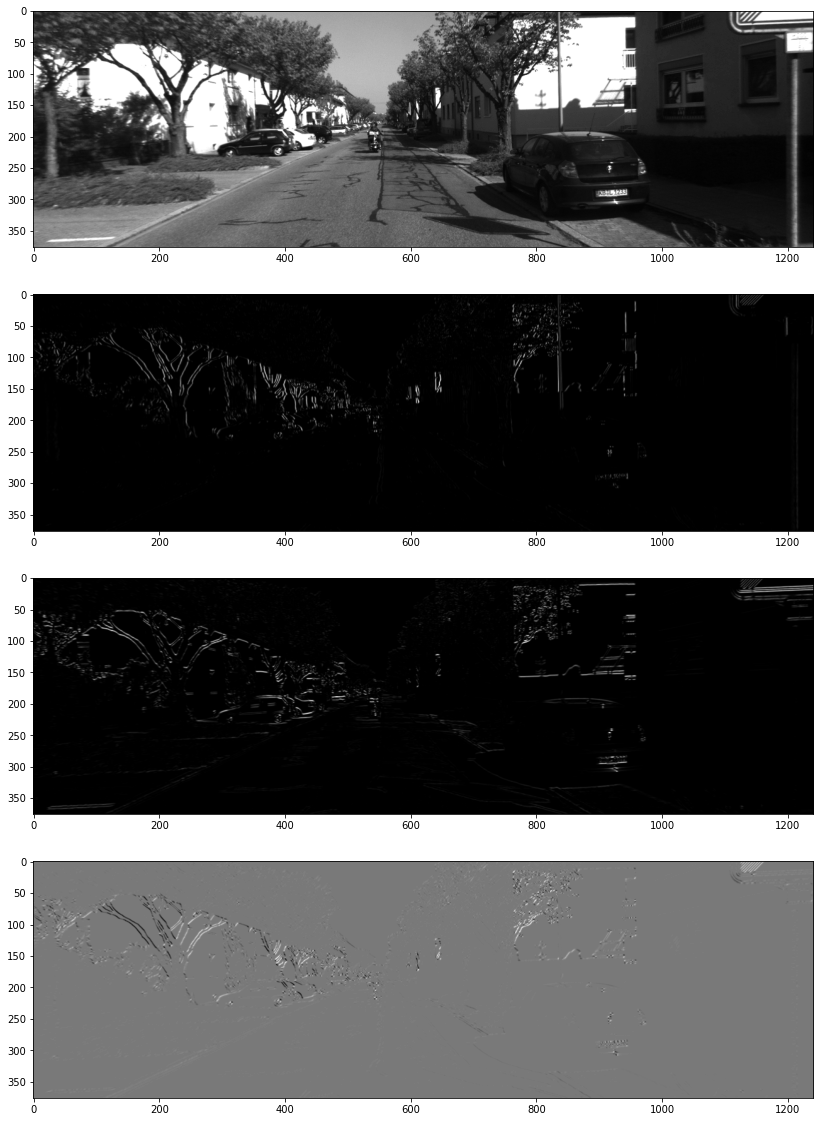

In [21]:
fig = plt.figure()
ax1 = fig.add_subplot(4,1,1)
ax1.imshow(image_list[0].img, cmap=plt.get_cmap('gray'))
ax2 = fig.add_subplot(4,1,2)
ax2.imshow(Ixx, cmap=plt.get_cmap('gray'))
ax3 = fig.add_subplot(4,1,3)
ax3.imshow(Iyy, cmap=plt.get_cmap('gray'))
ax4 = fig.add_subplot(4,1,4)
ax4.imshow(Ixy, cmap=plt.get_cmap('gray'))

## 3. Applying harris responce

In [22]:
def harris_response(Ixx, Iyy, Ixy, w = gaussian_kernel(5, 1)):
    Ixx = ndimage.filters.convolve(Ixx, w)
    Iyy = ndimage.filters.convolve(Iyy, w)
    Ixy = ndimage.filters.convolve(Ixy, w)
    R = Ixx * Iyy - Ixy * Ixy - 0.06 * (Ixx + Iyy) * (Ixx + Iyy)
    return R

## Applying harris_response to every point

In [23]:
for image in tqdm(image_list):
    image.get_R()

  0%|          | 0/200 [00:00<?, ?it/s]

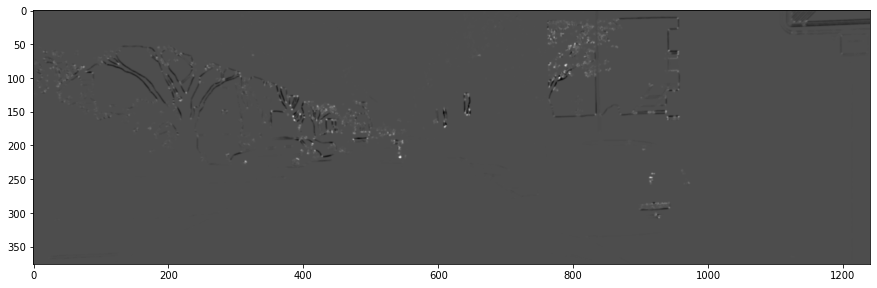

In [25]:
plt.imshow(image_list[0].R, cmap=plt.get_cmap('gray'))

In [26]:
def response_non_maxsup(R):
    coordinates = feature.peak.peak_local_max(R, 7, threshold_rel = 0.01)
    return coordinates

## 4. Applying response_non_maxsup to every point, so we can get the coordinates of each point

In [27]:
for image in tqdm(image_list):
    image.get_keypoints()

  0%|          | 0/200 [00:00<?, ?it/s]

In [28]:
def keypoints_vis(image, list_keypoints, show_image = 1):
    image =image*255
    image_color = cv.merge([image, image, image]).astype(np.uint8)
    #print(image_color)
    for keypoint in list_keypoints:
        cv.drawMarker ( image_color , ( keypoint[1] , keypoint[0]) , (255 ,0 ,0) , markerType = cv. 
                       MARKER_CROSS , markerSize =10 , thickness =2 ,line_type = cv.LINE_8 )
    if show_image == 1:
        
        plt.figure()
        plt.imshow(image_color)
        plt.axis( "off")
        plt.show()
    else :
        return image_color

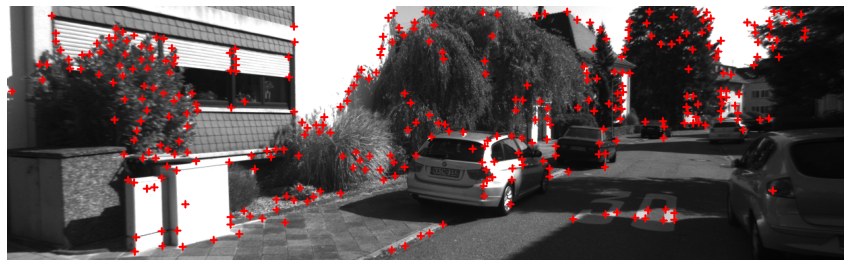

In [29]:
keypoints_vis(image_list[114].img, image_list[114].keypoints)

In [30]:
def make_video(img_array, name = 'corner_tracking_patch.mp4'):
    # reads the images
    '''
    img_array = []
    for filename in sorted(list_image_names):
        img = cv.imread(filename)
        img_array.append(img)
    '''
    img = img_array 
    # video size = image size
    height, width, layers = img[0].shape
    size = ( width , height )
    # create mp4 writer with 3 FPS
    video_wr = cv . VideoWriter ( name, cv.VideoWriter_fourcc(*'mp4v') , 3 , size )
    for i in range(len(img_array)):
        b,g,r = cv.split(img_array[i])           # get b, g, r
        img_array[i] = cv.merge([r,g,b])     # switch it to r, g, b
        video_wr.write(img_array[i])
    video_wr.release ()

In [31]:
imgarray = np.empty((0, 376, 1241, 3), dtype=np.uint8)
for i in range(200):
    a = keypoints_vis(image_list[i].img, image_list[i].keypoints, 0)
    imgarray = np.append(imgarray, [a], axis = 0)

In [34]:
make_video(imgarray, "Keypoints.mp4")

# Part III Corner Tracking with Patch Templates
## 1. returns a list of patches for the detected keypoints.

In [35]:
def return_patches(img, keypoints, N = 32):
    N_half = int(N / 2)
    img = cv.copyMakeBorder(img, top=N_half, bottom=N_half, left=N_half, right=N_half,     borderType=cv.BORDER_REPLICATE)
    keypoints = keypoints + N_half
    smallimgs = np.asarray([np.ones((N, N))] * keypoints.shape[0])
    imgsIdx = 0
    i = 0
    for keypoint in keypoints:
        for row in range(N):
            for column in range(N):
                smallimgs[imgsIdx][row][column] = img[keypoint[0] - N_half + row][keypoint[1] - N_half + column]
        imgsIdx = imgsIdx + 1
                
   # print(keypoints)
    return img, keypoints, smallimgs

## Getting patches(feature pic) of every keypoint

In [36]:
for image in tqdm(image_list):
    image.get_feature()

  0%|          | 0/200 [00:00<?, ?it/s]

## 2. Normalize the features

In [37]:
def normalize_patch(patch_list):
    for i in range(len(patch_list)):
        patch_list[i] = (patch_list[i] - np.mean(patch_list[i])) / (np.std(patch_list[i]) + 0.0000001)
    return patch_list

In [38]:
for image in tqdm(image_list):
    image.norm_patches()

  0%|          | 0/200 [00:00<?, ?it/s]

## match between frames

In [39]:
class match_between_frames():
    def __init__(self, image_list):
        self.matchlist = []
        for i in trange(len(image_list) - 1):# it is equivalent to use the commented line below. but using trange, we can have a progress bar
#for i in range(len(image_list) - 1):
            self.matchlist.append(distance_matrix(image_list[i].NormFeatureimgs, image_list[i + 1].NormFeatureimgs))
    def Min_Distance(self):
        self.min_distance = []
        for match in tqdm(self.matchlist): # it is equivalent to use the commented line below. but using trange, we can have a progress bar
#for i in range(len(matchlist)):
            self.min_distance.append(find_matches(match))
    def Ratio_Test(self):
        sortmatchlist = copy.deepcopy(self.matchlist)
        for i in range(len(sortmatchlist)):
            for j in range(sortmatchlist[i].shape[1]):
                sortmatchlist[i][:, j].sort()
        after_1NN_list = [] # matches after 1NN/2NN ratio test
        after_1NN = []
        match_index = 0
        for index in range(len(self.min_distance)):
#for min_distance in min_list:
            for i in range(len(self.min_distance[index])):
                if sortmatchlist[match_index][0][i] / sortmatchlist[match_index][1][i] < 0.8:
                    after_1NN.append(self.min_distance[index][i])
            after_1NN_list.append(after_1NN)
            after_1NN = []
            match_index = match_index + 1
        self.ratio_test = after_1NN_list
        
    def Cross_Validation_Test(self):
        def find_matches_reverse(distance_M):
            min_list = []
            for i in range(distance_M.shape[0]):
                indx = np.argmin(distance_M[i])
                min_list.append((i, indx))
            return min_list
        min_list_reverse = []
        for match in self.matchlist:
            min_list_reverse.append(find_matches_reverse(match))
        after_cross_list = [] # matches after 1NN/2NN ratio test
        after_cross = []
        index_match = 0
        for after_1NN in self.ratio_test:
            for coor_tuple in after_1NN:
                X, Y = coor_tuple
        #print(min_list_reverse[index_match][X], Y)
                if min_list_reverse[index_match][X][1] == Y:
        
                    after_cross.append(coor_tuple)
    #print(after_cross)
            after_cross_list.append(after_cross)
            after_cross = []
            index_match = index_match + 1
        self.cross_vali = after_cross_list
   

## 3. Brute force match

In [40]:
def distance_matrix(M1list, M2list):
    distance_M = np.ones((M1list.shape[0], M2list.shape[0]))
    for i in range(M1list.shape[0]):
        for j in range(M2list.shape[0]):
            distance_M[i,j] = np.square(np.linalg.norm(M1list[i] - M2list[j])) #** 2
            #distance_M[i,j] = np.linalg.norm(M1list[i] - M2list[j]) 
    return distance_M

## Brute force match for every image

In [41]:
matches = match_between_frames(image_list)

  0%|          | 0/199 [00:00<?, ?it/s]

## 4. Finding the min distance

In [43]:
def find_matches(distance_M):
    min_list = []
    for i in range(distance_M.shape[1]):
        indx = np.argmin(distance_M[:,i])
        min_list.append((indx, i))
    return min_list

## Finding the min distance in every match

In [44]:
matches.Min_Distance()

  0%|          | 0/199 [00:00<?, ?it/s]

In [45]:
## plot matched keypoints
# This function plots detected keypoints with red ’+’ markes over a grayscale image # inputs: target image, lists of src , list of target keypoints (in Numpy conventionorder), and list of matches
def matches_vis(image_tgt , list_keypoints_src , list_keypoints_tgt , matches, show_image = 1):
    # repeat channels for creating color image from grayscale
    image_tgt = image_tgt * 255
    image_color = cv.merge([image_tgt, image_tgt ,image_tgt]).astype(np.uint8)
    # add cross for each keypoint in target image for keyp in list_keypoints_tgt:
    for keyp in list_keypoints_tgt :
        cv.drawMarker(image_color , (keyp[1], keyp[0]), (255,0,0), markerType=cv.MARKER_CROSS , markerSize=10, thickness=2, line_type=cv.LINE_8)
    # draw green lines of matches 
    for (i,j) in matches:
        coord_src , coord_tgt = list_keypoints_src[i,:], list_keypoints_tgt[j,:]
        # please note that coordinates are inverted to follow opencv convention (x,y) instead of (y,x)
        cv.line(image_color ,(coord_tgt[1], coord_tgt[0]),(coord_src[1], coord_src[0]),(0 ,255 ,0) ,1)
    
    # display image
    if show_image == 1:
        plt.figure()
        plt.imshow(image_color) 
        plt.axis('off')
        plt.show()
    else : 
        return image_color

## Tracking results between the frames 114 and 115 (the motion of keypoints are indicated by the green lines).

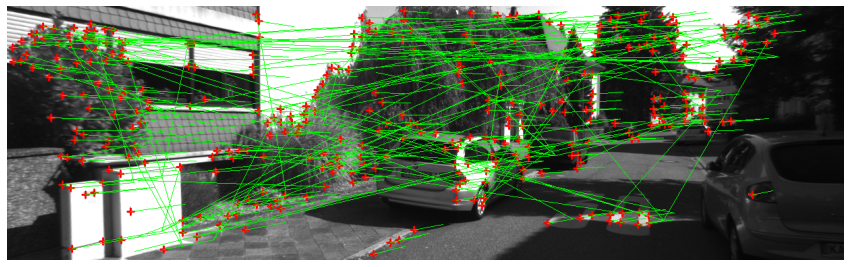

In [46]:
matches_vis(image_list[115].img, image_list[114].keypoints, image_list[115].keypoints, matches.min_distance[114])

## 5. 1NN / 2NN ratio test
## sort every column in every match

In [47]:
matches.Ratio_Test()

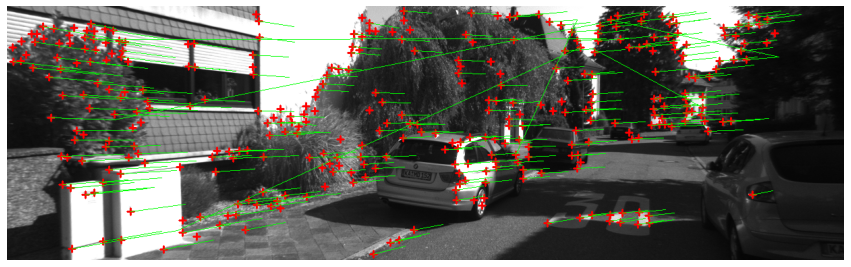

In [50]:
matches_vis(image_list[115].img, image_list[114].keypoints, image_list[115].keypoints, matches.ratio_test[114])

In [49]:
imgarray = np.empty((0, 376, 1241, 3), dtype=np.uint8)
for i in range(199):
    a = matches_vis(image_list[i+1].img, image_list[i].keypoints, image_list[i+1].keypoints, matches.ratio_test[i], 0)
    imgarray = np.append(imgarray, [a], axis = 0)

In [349]:
make_video(imgarray, "trace.mp4")

## 7. cross-validation test

In [51]:
matches.Cross_Validation_Test()

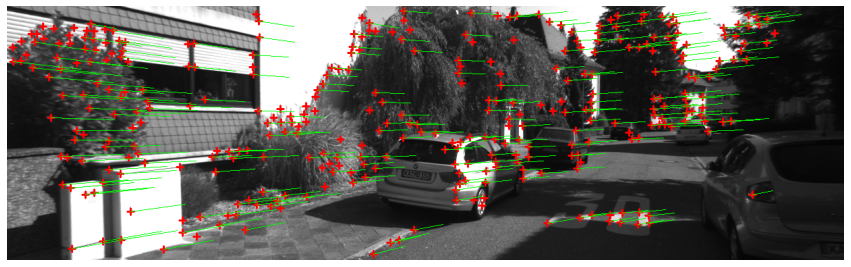

In [52]:
matches_vis(image_list[115].img, image_list[114].keypoints, image_list[115].keypoints, matches.cross_vali[114])

In [53]:
imgarray = np.empty((0, 376, 1241, 3), dtype=np.uint8)
for i in range(199):
    a = matches_vis(image_list[i+1].img, image_list[i].keypoints, image_list[i+1].keypoints, matches.cross_vali[i], 0)
    imgarray = np.append(imgarray, [a], axis = 0)

In [54]:
make_video(imgarray, "trace after cross vali.mp4")

## What is the average number of tracked keypoints per frame when considering two matching outlier tests?

In [65]:
total = 0
for i in range(199):
    total = total +len(matches.cross_vali[i])
total / 199

186.87437185929647

# Part IV - Corner Tracking with SIFT Features
## convert keypoints list into the appropriate structure, so we can use opencv

In [55]:
for image in image_list:
    image.SIFT_KP()

In [56]:
for image in tqdm(image_list):
    image.SIFT_Des()

  0%|          | 0/200 [00:00<?, ?it/s]

In [57]:
class SIFT_Matches(match_between_frames):
    def __init__(self, imagelist):
        #nimagelist = []
        self.matchlist = []
        '''
        
        for image in imagelist:
            image.NormFeatureimgs = image.des_sift
            nimagelist.append(image)
        self.matchlist = []
        '''
        for i in trange(len(image_list) - 1):# it is equivalent to use the commented line below. but using trange, we can have a progress bar
#for i in range(len(image_list) - 1):
            self.matchlist.append(distance_matrix(image_list[i].SIFT_des, image_list[i + 1].SIFT_des))
        


In [58]:
siftmatches = SIFT_Matches(image_list)

  0%|          | 0/199 [00:00<?, ?it/s]

In [59]:
siftmatches.Min_Distance()

  0%|          | 0/199 [00:00<?, ?it/s]

In [60]:
siftmatches.Ratio_Test()

In [61]:
siftmatches.Cross_Validation_Test()

In [82]:
total = 0
for i in range(199):
    total = total + len(siftmatches.cross_vali[i])

In [83]:
total / 199

90.96482412060301

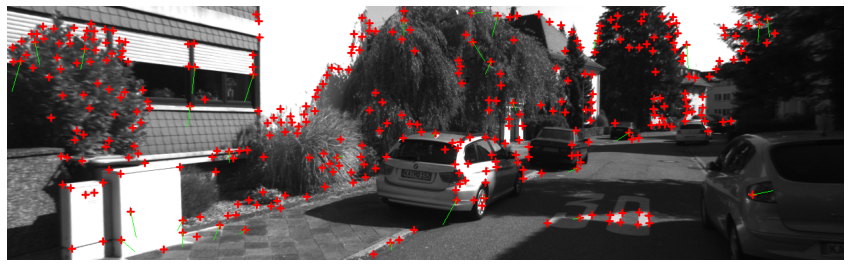

In [62]:
matches_vis(image_list[115].img, image_list[114].keypoints, image_list[115].keypoints, siftmatches.cross_vali[114])

In [63]:
imgarray = np.empty((0, 376, 1241, 3), dtype=np.uint8)
for i in range(199):
    a = matches_vis(image_list[i+1].img, image_list[i].keypoints, image_list[i+1].keypoints, siftmatches.cross_vali[i], 0)
    imgarray = np.append(imgarray, [a], axis = 0)

In [64]:
make_video(imgarray, "SIFT after cross vali SIFT.mp4")